<a href="https://colab.research.google.com/github/Upendra4204/Upendra4204/blob/main/Copy_of_NLP_Speech_Recognition_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tensorflow-speech-recognition-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F7634%2F46676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240228%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240228T050337Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D429300d5c6786c6b9808148ffa9ae839b3f0e60eadecd81aaa49d3ce1a06d116597932d94d63e7c60716d375dfe9d71d9ad2073844e24b4b7fa0941d67a59ccc1766b32fdb1413757c9246fee184bb99370dee1c71b633b9ac1898351e63c1a4005490b358f538b8b45d97a664d97e34665155bfe8febfe189556266ec90570a8b88a32ba8bbc83ca516fee22c3ee68b8160ee0083a0789e795139c0861a9e40ec6fd78386efa13d69c32fe325a3accc121cd4467cfef8f4f5654441d56a7d8a805003ef66c00d855e44ab2f748adc185d5e1b16c1fb5cd4ea63e8a0c51bad379a5f119cd457c0c364aa3c5b111fd28892be60b2ed6d849cd4499129b10d39c7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3763443908 bytes downloaded
Downloaded and uncompressed: tensorflow-speech-recognition-challenge
Data source import complete.


In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tensorflow-speech-recognition-challenge/link_to_gcp_credits_form.txt
/kaggle/input/tensorflow-speech-recognition-challenge/train.7z
/kaggle/input/tensorflow-speech-recognition-challenge/test.7z
/kaggle/input/tensorflow-speech-recognition-challenge/sample_submission.7z


In [3]:
!pip install pyunpack
#allows you to extract files from various compressed formats like ZIP, RAR, 7z, etc
!pip install patool
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.6 MB/s eta 0:00:00


In [4]:
from py7zr import unpack_7zarchive
import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('/kaggle/input/tensorflow-speech-recognition-challenge/train.7z', '/kaggle/working/tensorflow-speech-recognition-challenge/train/')

In [5]:
# from pyunpack import Archive
# import shutil
# if not os.path.exists('/kaggle/working/tensorflow-speech-recognition-challenge/train/'):
#     os.makedirs('/kaggle/working/tensorflow-speech-recognition-challenge/train/')
# Archive('/kaggle/input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/tensorflow-speech-recognition-challenge/train/')

for dirname, _, filenames in os.walk('/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio'):
    for filename in filename[:5]:
        print(os.path.join(dirname, filename))

/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/s
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/a
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/m
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/p
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/cat/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/seven/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/sheila/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/four/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/six/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/wow/l
/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/happy/l
/kaggle/working/tensorflow-speech-recognition-challe

# <center> Implementing the Speech-to-Text Model in Python
**Understanding the Problem Statement for our Speech-to-Text Project**

Let’s understand the problem statement of our project before we move into the implementation part.

We might be on the verge of having too many screens around us. It seems like every day, new versions of common objects are “re-invented” with built-in wifi and bright touchscreens. A promising antidote to our screen addiction is voice interfaces.

__You can download the dataset from__ [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
    
TensorFlow recently released the Speech Commands Datasets. It includes 65,000 one-second long utterances of 30 short words, by thousands of different people. We’ll build a speech recognition system that understands simple spoken commands. <br>    
__Reference Aticle__ [Click here](https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/) to understand the basics of signal processing prior implementing the speech to text.

**Import the libraries**

First, import all the necessary libraries into our notebook. LibROSA and SciPy are the Python libraries used for processing audio signals.

In [6]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

import librosa
import IPython.display as ipd
from scipy.io import wavfile

**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way.

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

In [7]:
train_audio_path = '/kaggle/working/tensorflow-speech-recognition-challenge/train/train/audio/'

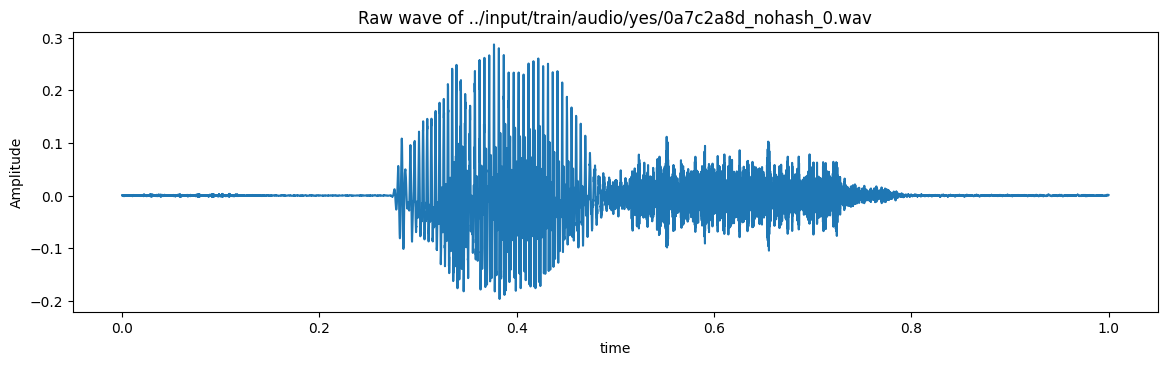

In [8]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

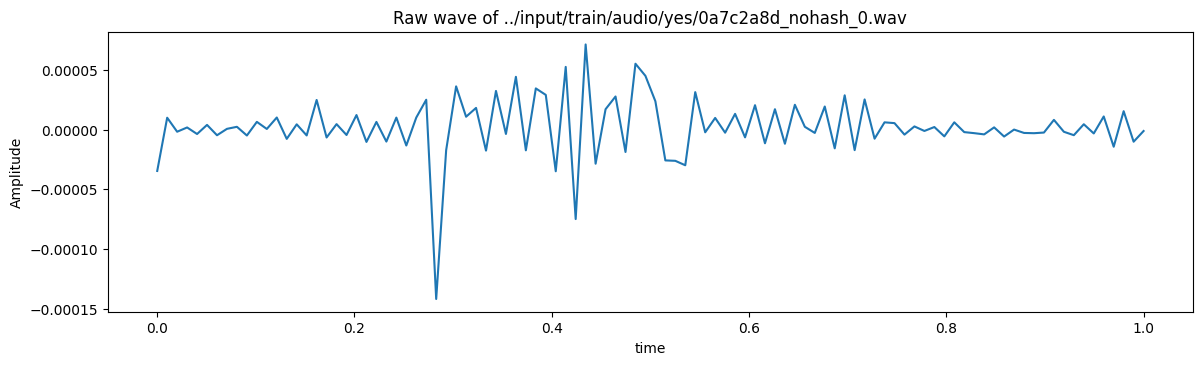

In [9]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 100)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

**Sampling rate**

Let us now look at the sampling rate of the audio signals

In [10]:
sample_rate=40000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [11]:
sample_rate=16000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [12]:
sample_rate=6000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [31]:
sample_rate=3000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

**Resampling**

From the above, we can understand that the sampling rate of the signal is 16000 hz. Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000z

In [37]:
samples = librosa.resample(samples,orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples, rate=8000)

Now, let’s understand the number of recordings for each voice command:

In [38]:
labels=os.listdir(train_audio_path)

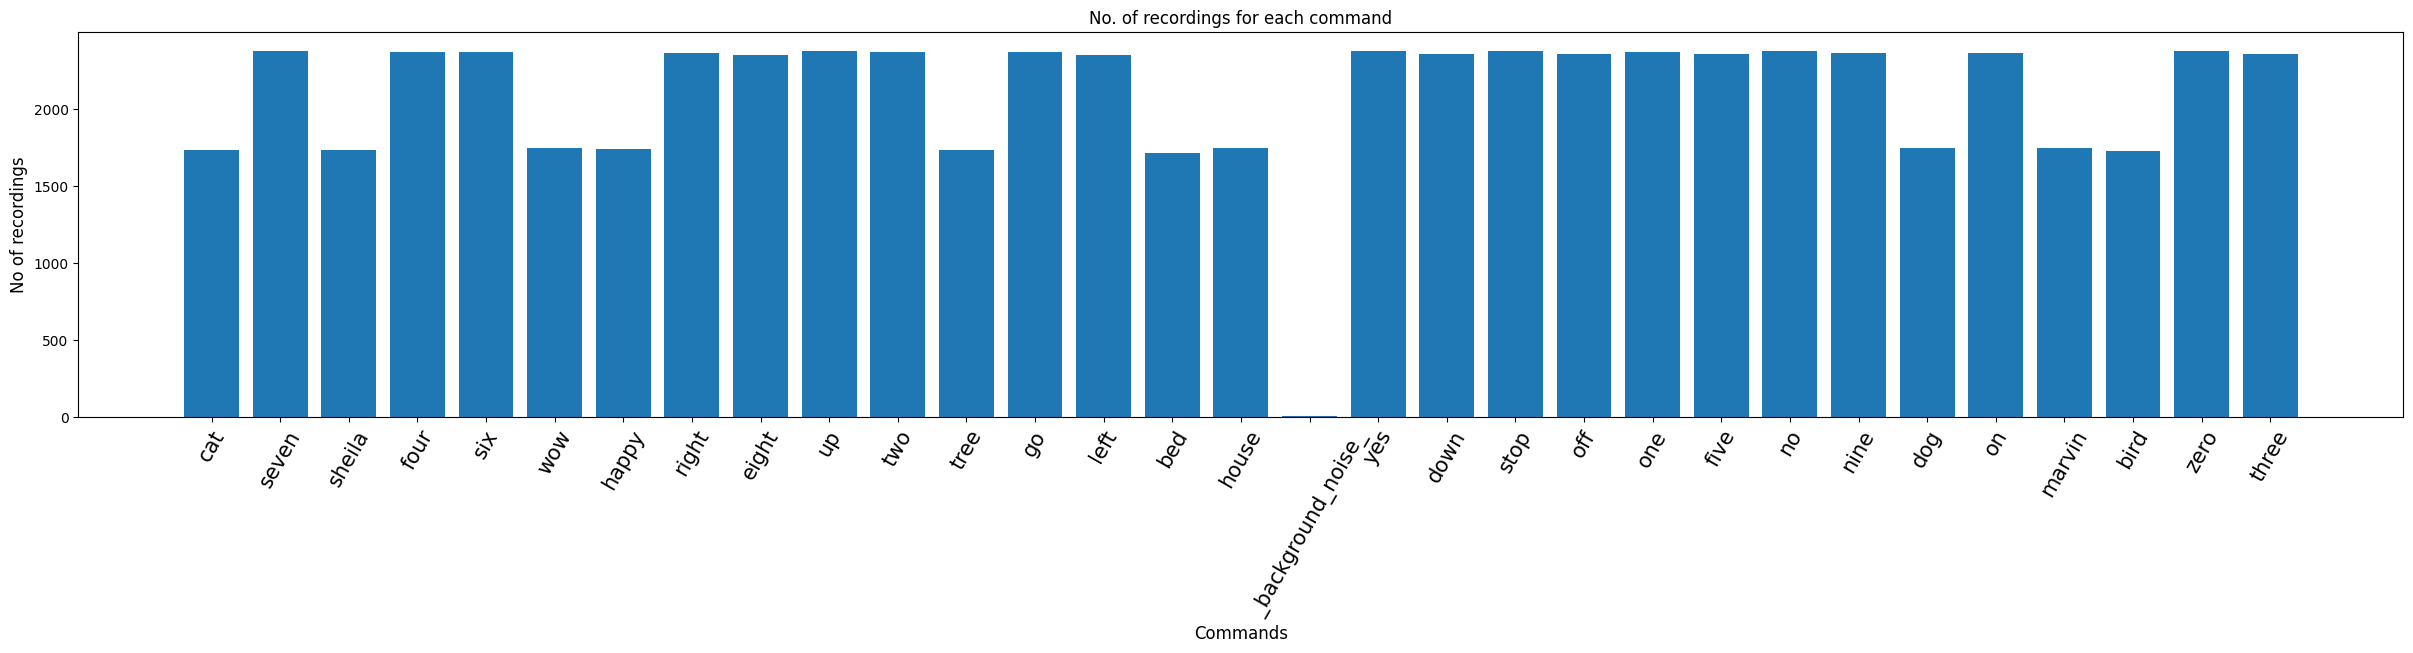

In [39]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [40]:
# labels=["yes", "no","stop", "go"]
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

**Duration of recordings**

What’s next? A look at the distribution of the duration of recordings:

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

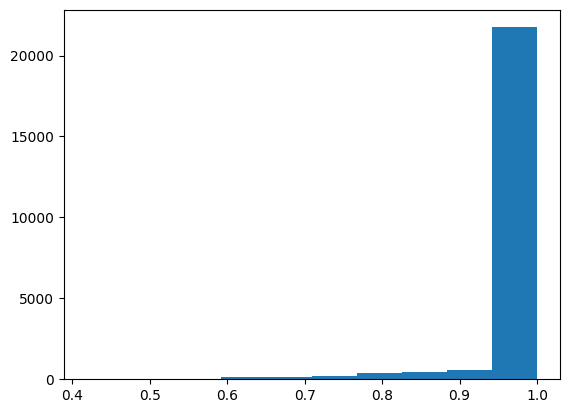

In [41]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings))

**Preprocessing the audio waves**

In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

Here are the two steps we’ll follow:

* Resampling
* Removing shorter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [42]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) :
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [43]:
print(type(all_wave))
print(len(all_wave))

<class 'list'>
21312


In [44]:
print(len(all_wave))
print(all_wave[1].shape)
all_wave[1]

21312
(8000,)


array([-0.00037255, -0.00061751, -0.00054744, ...,  0.00074413,
        0.00072226,  0.00064864], dtype=float32)

Convert the output labels to integer encoded:

In [45]:
len(set(all_label))

10

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [47]:
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [50]:
pip install keras==2.3.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.3.1 which is incompatible.


In [51]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [ ]:
y

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [52]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [53]:
all_wave.shape

(21312, 8000, 1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [54]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture for this problem**

We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension.

**Model building**

Let us implement the model using Keras functional API.

### Conv1D, Conv2D and Conv3D : https://xzz201920.medium.com/conv1d-conv2d-and-conv3d-8a59182c4d6

In [55]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

In [56]:
# ?Conv1D

In [70]:
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

In [72]:
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(filters=8,kernel_size=13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 884, 16)           0         
 g1D)                                                        

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [73]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [75]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 2.1017 - accuracy: 0.2029

533/533 [==============================] - 146s 268ms/step - loss: 2.1017 - accuracy: 0.2029 - val_loss: 1.8762 - val_accuracy: 0.3134
Epoch 2/100
533/533 [==============================] - ETA: 0s - loss: 1.4782 - accuracy: 0.4527

533/533 [==============================] - 132s 248ms/step - loss: 1.4782 - accuracy: 0.4527 - val_loss: 1.4364 - val_accuracy: 0.4999
Epoch 3/100
533/533 [==============================] - ETA: 0s - loss: 1.1065 - accuracy: 0.6047

533/533 [==============================] - 135s 252ms/step - loss: 1.1065 - accuracy: 0.6047 - val_loss: 0.9995 - val_accuracy: 0.6573
Epoch 4/100
533/533 [==============================] - ETA: 0s - loss: 0.9379 - accuracy: 0.6679

533/533 [==============================] - 135s 253ms/step - loss: 0.9379 - accuracy: 0.6679 - val_loss: 0.7961 - val_accuracy: 0.7225
Epoch 5/100
533/533 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.7031

533/533 [==============================] - 148s 278ms/step - loss: 0.8421 - accuracy: 0.7031 - val_loss: 0.7949 - val_accuracy: 0.7223
Epoch 6/100
533/533 [==============================] - ETA: 0s - loss: 0.7802 - accuracy: 0.7257

533/533 [==============================] - 134s 251ms/step - loss: 0.7802 - accuracy: 0.7257 - val_loss: 0.6895 - val_accuracy: 0.7668
Epoch 7/100
533/533 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7471

533/533 [==============================] - 130s 243ms/step - loss: 0.7169 - accuracy: 0.7471 - val_loss: 0.6231 - val_accuracy: 0.7912
Epoch 8/100
533/533 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7644

533/533 [==============================] - 140s 262ms/step - loss: 0.6692 - accuracy: 0.7644 - val_loss: 0.6118 - val_accuracy: 0.7990
Epoch 9/100
533/533 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7834

533/533 [==============================] - 132s 247ms/step - loss: 0.6285 - accuracy: 0.7834 - val_loss: 0.6588 - val_accuracy: 0.7680
Epoch 10/100
533/533 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7887

533/533 [==============================] - 127s 238ms/step - loss: 0.5987 - accuracy: 0.7887 - val_loss: 0.6460 - val_accuracy: 0.7734
Epoch 11/100
533/533 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.7955

533/533 [==============================] - 132s 248ms/step - loss: 0.5863 - accuracy: 0.7955 - val_loss: 0.5583 - val_accuracy: 0.8128
Epoch 12/100
533/533 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.8037

533/533 [==============================] - 126s 237ms/step - loss: 0.5533 - accuracy: 0.8037 - val_loss: 0.5320 - val_accuracy: 0.8173
Epoch 13/100
533/533 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.8159

533/533 [==============================] - 131s 246ms/step - loss: 0.5268 - accuracy: 0.8159 - val_loss: 0.5219 - val_accuracy: 0.8295
Epoch 14/100
533/533 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8229

533/533 [==============================] - 129s 243ms/step - loss: 0.5056 - accuracy: 0.8229 - val_loss: 0.5001 - val_accuracy: 0.8365
Epoch 15/100
533/533 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8301

533/533 [==============================] - 129s 242ms/step - loss: 0.4817 - accuracy: 0.8301 - val_loss: 0.5135 - val_accuracy: 0.8311
Epoch 16/100
533/533 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8373

533/533 [==============================] - 131s 247ms/step - loss: 0.4696 - accuracy: 0.8373 - val_loss: 0.5311 - val_accuracy: 0.8241
Epoch 17/100
533/533 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.8381

533/533 [==============================] - 131s 247ms/step - loss: 0.4733 - accuracy: 0.8381 - val_loss: 0.5259 - val_accuracy: 0.8290
Epoch 18/100
533/533 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8488

533/533 [==============================] - 147s 275ms/step - loss: 0.4387 - accuracy: 0.8488 - val_loss: 0.4959 - val_accuracy: 0.8330
Epoch 19/100
533/533 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8533

533/533 [==============================] - 145s 272ms/step - loss: 0.4201 - accuracy: 0.8533 - val_loss: 0.4873 - val_accuracy: 0.8393
Epoch 20/100
533/533 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8554

533/533 [==============================] - 142s 267ms/step - loss: 0.4152 - accuracy: 0.8554 - val_loss: 0.5467 - val_accuracy: 0.8156
Epoch 21/100
533/533 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8613

533/533 [==============================] - 143s 268ms/step - loss: 0.3934 - accuracy: 0.8613 - val_loss: 0.4842 - val_accuracy: 0.8445
Epoch 22/100
533/533 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.8591

533/533 [==============================] - 136s 255ms/step - loss: 0.4060 - accuracy: 0.8591 - val_loss: 0.4984 - val_accuracy: 0.8388
Epoch 23/100
533/533 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8647

533/533 [==============================] - 141s 265ms/step - loss: 0.3866 - accuracy: 0.8647 - val_loss: 0.5122 - val_accuracy: 0.8330
Epoch 24/100
533/533 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8704

533/533 [==============================] - 137s 257ms/step - loss: 0.3781 - accuracy: 0.8704 - val_loss: 0.4929 - val_accuracy: 0.8400
Epoch 25/100
533/533 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8754

533/533 [==============================] - 140s 263ms/step - loss: 0.3651 - accuracy: 0.8754 - val_loss: 0.4781 - val_accuracy: 0.8480
Epoch 26/100
533/533 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8792

533/533 [==============================] - 135s 254ms/step - loss: 0.3419 - accuracy: 0.8792 - val_loss: 0.4458 - val_accuracy: 0.8529
Epoch 27/100
533/533 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8786

533/533 [==============================] - 138s 259ms/step - loss: 0.3595 - accuracy: 0.8786 - val_loss: 0.4981 - val_accuracy: 0.8356
Epoch 28/100
533/533 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8812

533/533 [==============================] - 140s 263ms/step - loss: 0.3366 - accuracy: 0.8812 - val_loss: 0.4519 - val_accuracy: 0.8550
Epoch 29/100
533/533 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8879

533/533 [==============================] - 138s 260ms/step - loss: 0.3219 - accuracy: 0.8879 - val_loss: 0.4795 - val_accuracy: 0.8400
Epoch 30/100
533/533 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.8857

533/533 [==============================] - 136s 256ms/step - loss: 0.3298 - accuracy: 0.8857 - val_loss: 0.5359 - val_accuracy: 0.8325
Epoch 31/100
533/533 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8840

533/533 [==============================] - 148s 277ms/step - loss: 0.3294 - accuracy: 0.8840 - val_loss: 0.5119 - val_accuracy: 0.8288
Epoch 32/100
533/533 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8920

533/533 [==============================] - 135s 254ms/step - loss: 0.3181 - accuracy: 0.8920 - val_loss: 0.5114 - val_accuracy: 0.8370
Epoch 33/100
533/533 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8921

533/533 [==============================] - 134s 252ms/step - loss: 0.3225 - accuracy: 0.8921 - val_loss: 0.5115 - val_accuracy: 0.8344
Epoch 34/100
533/533 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8916

533/533 [==============================] - 131s 245ms/step - loss: 0.3112 - accuracy: 0.8916 - val_loss: 0.4881 - val_accuracy: 0.8381
Epoch 35/100
533/533 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8938

533/533 [==============================] - 126s 237ms/step - loss: 0.3031 - accuracy: 0.8938 - val_loss: 0.4834 - val_accuracy: 0.8478
Epoch 36/100
533/533 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8974

533/533 [==============================] - 128s 241ms/step - loss: 0.2997 - accuracy: 0.8974 - val_loss: 0.4665 - val_accuracy: 0.8529
Epoch 36: early stopping


**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

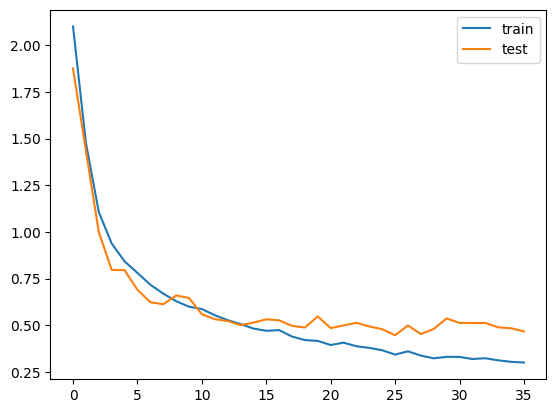

In [76]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

In [77]:
from keras.models import load_model
model.save("SpeechRecogModel.h5")

Define the function that predicts text for the given audio:

In [78]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [79]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: yes


In [80]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 188ms/step
Text: yes


**The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:**

In [ ]:
# # ! pip install sounddevice==0.2.1

# import sounddevice as sd
# import soundfile as sf

In [ ]:
# samplerate = 16000
# duration = 1 # seconds
# filename = 'yes.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

Let us now read the saved voice command and convert it to text:

In [ ]:
# #reading the voice commands
# samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
# samples = librosa.resample(samples, sample_rate, 8000)
# ipd.Audio(samples,rate=8000)

In [ ]:
# #converting voice commands to text
# predict(samples)

**Congratulations! You have just built your very own speech-to-text model!**